In [28]:
import d4rl
import gym
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [29]:

def plot_reward_and_action_norm_distributions(dataset, unsafe_region_reward=None, 
                                               unsafe_region_norm=None, title="Dataset Distributions"):
    """
    Plot histograms of reward distribution and action norm distribution.
    
    Args:
        dataset: Dataset dictionary with 'rewards' and 'actions' keys
        unsafe_region_reward: Tuple (min, max) for unsafe reward range (optional)
        unsafe_region_norm: Tuple (min, max) for unsafe action norm range (optional)
        title: Main title for the figure
    """
    actions = dataset['actions']
    action_norms = np.linalg.norm(actions, axis=1)
    rewards = dataset['rewards']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Reward distribution
    axes[0].hist(rewards, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
    axes[0].set_xlabel('Reward', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Reward Distribution', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    # Highlight unsafe reward region
    if unsafe_region_reward is not None:
        axes[0].axvspan(unsafe_region_reward[0], unsafe_region_reward[1], 
                       alpha=0.2, color='red', label='Unsafe Region')
        axes[0].legend()
    
    # Add statistics text
    stats_text = f'Mean: {np.mean(rewards):.2f}\nStd: {np.std(rewards):.2f}\nMin: {np.min(rewards):.2f}\nMax: {np.max(rewards):.2f}'
    axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=10)
    
    # Plot 2: Action norm distribution
    axes[1].hist(action_norms, bins=50, alpha=0.7, edgecolor='black', color='darkorange')
    axes[1].set_xlabel('Action L2 Norm', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Action Norm Distribution', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    # Highlight unsafe norm region
    if unsafe_region_norm is not None:
        axes[1].axvspan(unsafe_region_norm[0], unsafe_region_norm[1], 
                       alpha=0.2, color='red', label='Unsafe Region')
        axes[1].legend()
    
    # Add statistics text
    stats_text = f'Mean: {np.mean(action_norms):.2f}\nStd: {np.std(action_norms):.2f}\nMin: {np.min(action_norms):.2f}\nMax: {np.max(action_norms):.2f}'
    axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=10)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_samples(full_dataset, sparse_dataset, unsafe_region_reward=None, unsafe_region_norm=None, 
                title="Action Norm vs Reward - Before/After"):
    """
    Plot sample-wise action norm vs rewards for full and sparse datasets overlaid.
    
    Args:
        full_dataset: Original full dataset (plotted in blue)
        sparse_dataset: Sparse dataset after filtering (plotted in red)
        unsafe_region_reward: Tuple (min, max) for unsafe reward range
        unsafe_region_norm: Tuple (min, max) for unsafe action norm range
        title: Plot title
    """
    plt.figure(figsize=(12, 7))
    
    # Plot full dataset in blue
    actions_full = full_dataset['actions']
    action_norms_full = np.linalg.norm(actions_full, axis=1)
    rewards_full = full_dataset['rewards']
    
    plt.scatter(action_norms_full, rewards_full, alpha=0.3, s=3, c='blue', label='Full Dataset')
    
    # Plot sparse dataset in red on top
    actions_sparse = sparse_dataset['actions']
    action_norms_sparse = np.linalg.norm(actions_sparse, axis=1)
    rewards_sparse = sparse_dataset['rewards']
    
    plt.scatter(action_norms_sparse, rewards_sparse, alpha=0.5, s=3, c='red', label='Sparse Dataset')
    
    plt.title(f'{title}', fontsize=14)
    plt.xlabel('Action L2 Norm', fontsize=12)
    plt.ylabel('Reward', fontsize=12)
    
    # Highlight unsafe region if provided
    if unsafe_region_reward is not None and unsafe_region_norm is not None:
        from matplotlib.patches import Rectangle
        rect = Rectangle((unsafe_region_norm[0], unsafe_region_reward[0]), 
                         unsafe_region_norm[1] - unsafe_region_norm[0],
                         unsafe_region_reward[1] - unsafe_region_reward[0],
                         linewidth=2, edgecolor='black', facecolor='yellow', alpha=0.2,
                         label='Unsafe Region')
        plt.gca().add_patch(rect)
    
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_contour_action_norm_vs_reward(dataset, title="Action Norm vs Reward Contour", 
                                        bins=20, unsafe_region_reward=None, 
                                        unsafe_region_norm=None, cmap='viridis'):
    """
    Create a contour plot showing the density of action norm vs reward samples.
    
    Args:
        dataset: Dataset dictionary with 'rewards' and 'actions' keys
        title: Title for the plot
        bins: Number of bins for the 2D histogram (default: 50)
        unsafe_region_reward: Tuple (min, max) for unsafe reward range (optional)
        unsafe_region_norm: Tuple (min, max) for unsafe action norm range (optional)
        cmap: Colormap for the contour plot (default: 'viridis')
    """
    # Compute action norms
    actions = dataset['actions']
    action_norms = np.linalg.norm(actions, axis=1)
    state_norms = np.linalg.norm(dataset['observations'], axis=1)
    # rewards = dataset['rewards']
    
    # Create 2D histogram
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Add padding to the range to avoid cutting off the distribution
    norm_range = action_norms.max() - action_norms.min()
    reward_range = state_norms.max() - state_norms.min()
    norm_padding = norm_range * 0.1  # 10% padding
    reward_padding = reward_range * 0.1  # 10% padding
    
    # Compute histogram with extended range
    hist, xedges, yedges = np.histogram2d(
        action_norms, state_norms, bins=bins,
        range=[[action_norms.min() - norm_padding, action_norms.max() + norm_padding],
               [state_norms.min() - reward_padding, state_norms.max() + reward_padding]]
    )
    
    # Create meshgrid for contour plot
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    
    # Create filled contour plot
    contour = ax.contourf(X, Y, hist.T, levels=20, cmap=cmap, alpha=0.8)
    
    # Add contour lines
    contour_lines = ax.contour(X, Y, hist.T, levels=10, colors='black', alpha=0.3, linewidths=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax, label='Sample Density')
    
    # Highlight unsafe region if provided
    if unsafe_region_reward is not None and unsafe_region_norm is not None:
        from matplotlib.patches import Rectangle
        rect = Rectangle((unsafe_region_norm[0], unsafe_region_reward[0]), 
                         unsafe_region_norm[1] - unsafe_region_norm[0],
                         unsafe_region_reward[1] - unsafe_region_reward[0],
                         linewidth=2, edgecolor='red', facecolor='none', 
                         linestyle='--', label='Unsafe Region')
        ax.add_patch(rect)
        ax.legend(fontsize=10)
    
    ax.set_xlabel('Action L2 Norm', fontsize=12)
    ax.set_ylabel('State L2 Norm', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [30]:
with open('/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-2.pkl', 'rb') as f:
    ood_2 = pickle.load(f)

with open('/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-3.pkl', 'rb') as f:
    ood_3 = pickle.load(f)

with open('/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-4.pkl', 'rb') as f:
    ood_4 = pickle.load(f)
with open('/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-1.pkl', 'rb') as f:
    ood_1= pickle.load(f)

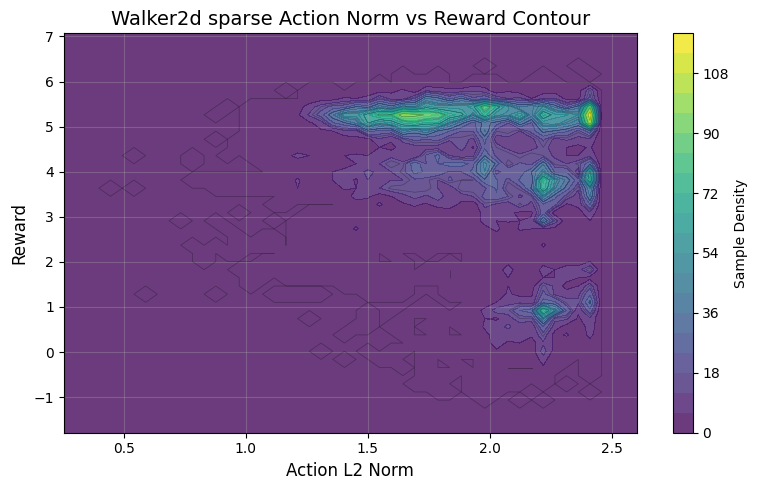

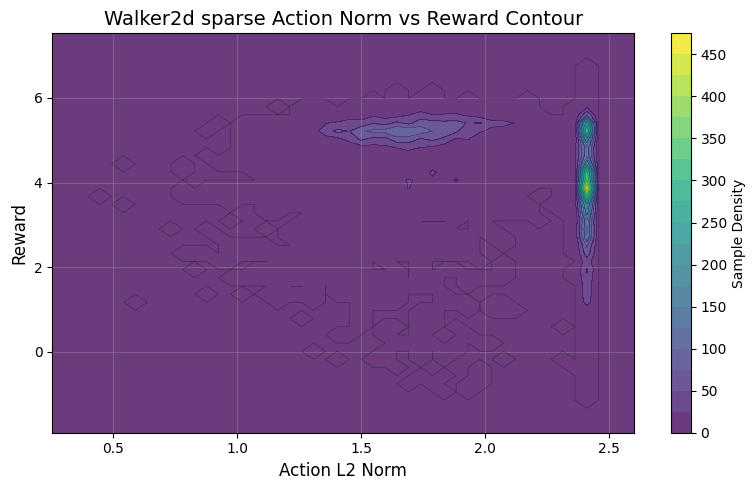

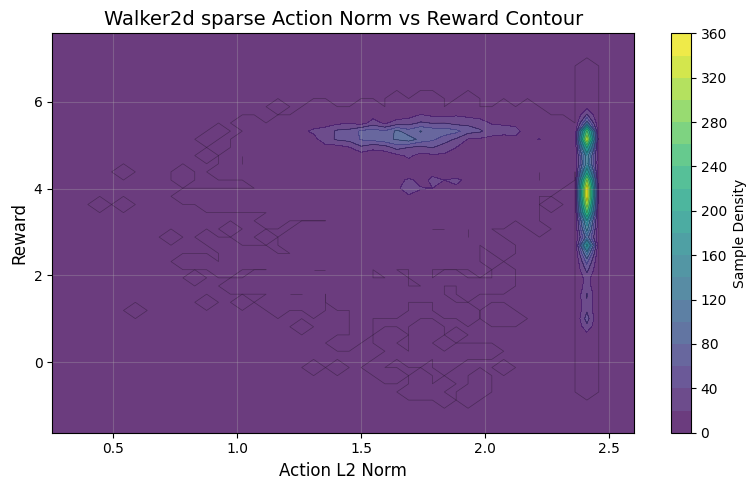

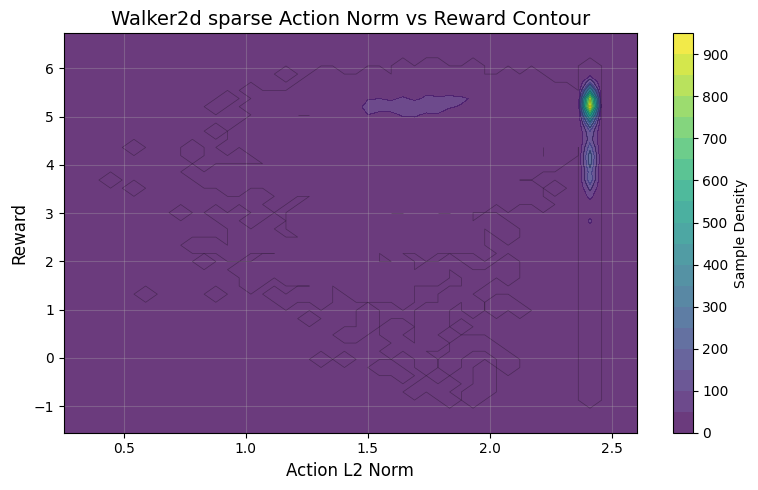

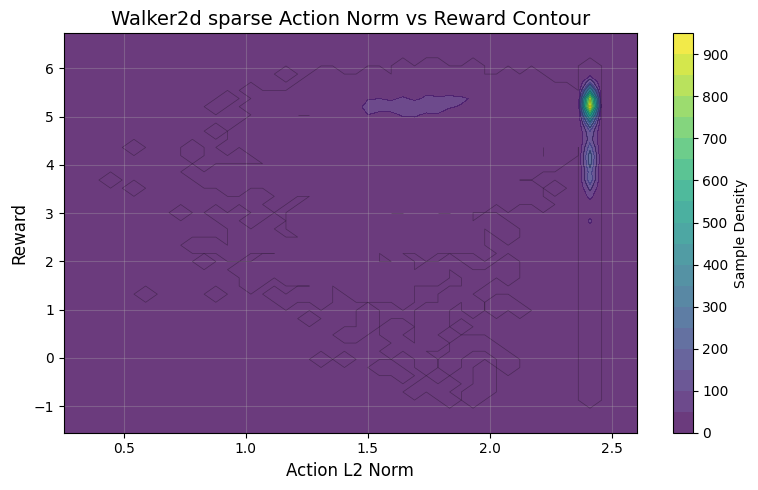

In [27]:
# fig = plot_trajectory_distribution(ood_2, 
#                                         f"Walker2d-ood - Sparse Trajectories")
# plt.savefig(f'{env_type}_sparse_trajectories.png', dpi=150, bbox_inches='tight')
# plt.show()

# Plot sample-wise action norm vs rewards (before/after comparison)
# print("\n--- Sample-wise comparison plot ---")
# plot_samples(dset, sparse_dataset_traj, unsafe_reward_range, unsafe_norm_range,
#             title=f"{env_type.upper()} - Full vs Sparse Dataset (sample-wise)")
plot_contour_action_norm_vs_reward(
ood_1, 
title=f"Walker2d sparse Action Norm vs Reward Contour",
bins=50,
unsafe_region_reward=None,
unsafe_region_norm=None,
cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
ood_2, 
title=f"Walker2d sparse Action Norm vs Reward Contour",
bins=50,
unsafe_region_reward=None,
unsafe_region_norm=None,
cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
ood_3, 
title=f"Walker2d sparse Action Norm vs Reward Contour",
bins=50,
unsafe_region_reward=None,
unsafe_region_norm=None,
cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
ood_4, 
title=f"Walker2d sparse Action Norm vs Reward Contour",
bins=50,
unsafe_region_reward=None,
unsafe_region_norm=None,
cmap='viridis'
    )


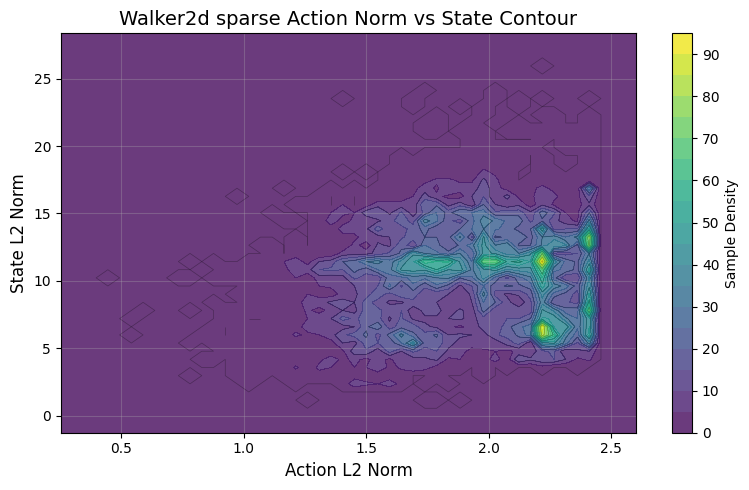

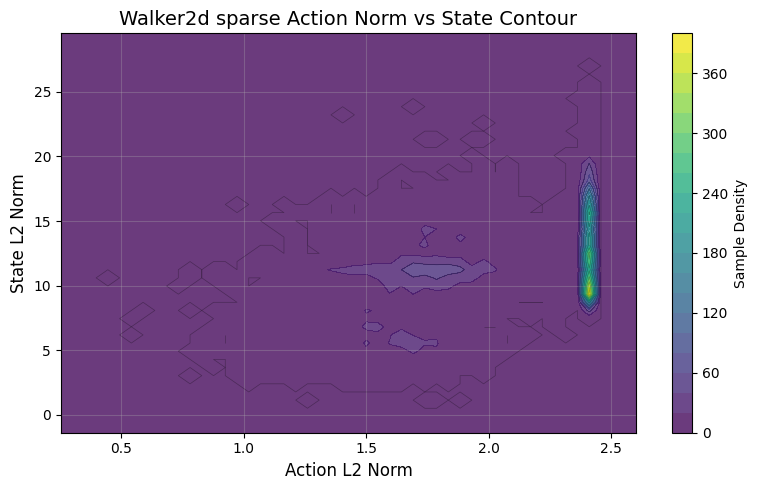

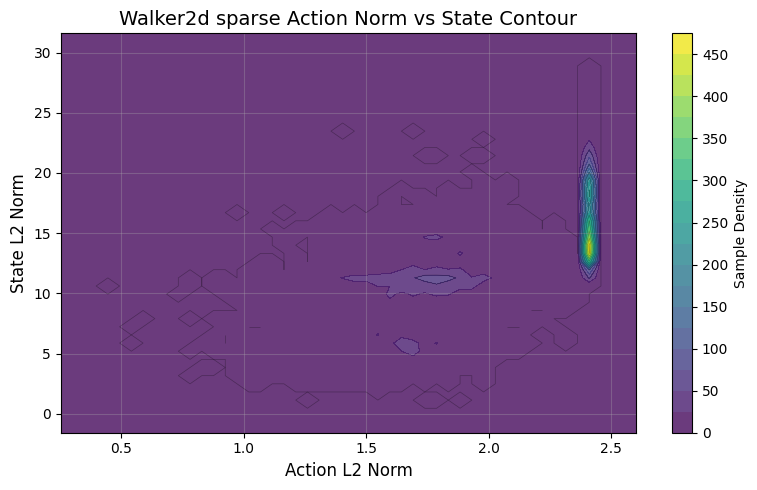

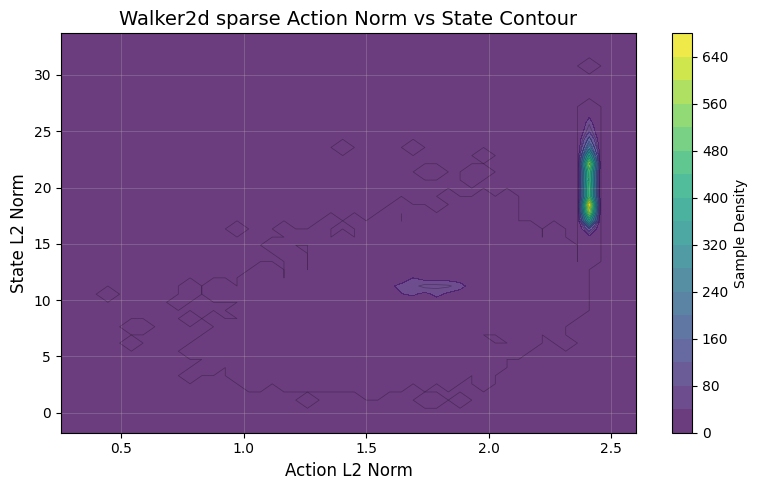

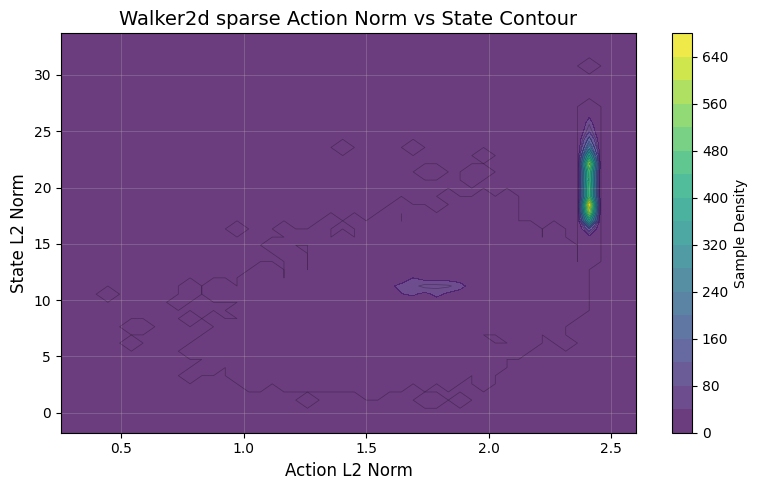

In [31]:
# fig = plot_trajectory_distribution(ood_2, 
#                                         f"Walker2d-ood - Sparse Trajectories")
# plt.savefig(f'{env_type}_sparse_trajectories.png', dpi=150, bbox_inches='tight')
# plt.show()

# Plot sample-wise action norm vs rewards (before/after comparison)
# print("\n--- Sample-wise comparison plot ---")
# plot_samples(dset, sparse_dataset_traj, unsafe_reward_range, unsafe_norm_range,
#             title=f"{env_type.upper()} - Full vs Sparse Dataset (sample-wise)")
plot_contour_action_norm_vs_reward(
ood_1, 
title=f"Walker2d sparse Action Norm vs State Contour",
bins=50,
unsafe_region_reward=None,
unsafe_region_norm=None,
cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
ood_2, 
title=f"Walker2d sparse Action Norm vs State Contour",
bins=50,
unsafe_region_reward=None,
unsafe_region_norm=None,
cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
ood_3, 
title=f"Walker2d sparse Action Norm vs State Contour",
bins=50,
unsafe_region_reward=None,
unsafe_region_norm=None,
cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
ood_4, 
title=f"Walker2d sparse Action Norm vs State Contour",
bins=50,
unsafe_region_reward=None,
unsafe_region_norm=None,
cmap='viridis'
    )
